In [1]:
import os
from lib.train_AI_lib import *
import cv2
import numpy as np

In [2]:
os.chdir('..')

In [3]:
def createMask(bboxes, imgRes=(1024, 2014)):
    globalMask = np.zeros(imgRes, dtype=bool)
    for bbox in bboxes:
        oneMask = np.zeros(imgRes, dtype=bool)
        bbox = [int(number) for number in bbox]
        # Don't ask me why this flip works, numpy and cv2 take images in differently and it's a pain to try and figure out the transformations    
        oneMask[bbox[0]:(bbox[0]+bbox[2]), imgRes[1]-(bbox[1]+bbox[3]):imgRes[1]-bbox[1]] = np.ones((bbox[2], bbox[3]), dtype=bool)
        globalMask = np.bitwise_or(globalMask, oneMask)
    globalMask = np.rot90(globalMask, 1)
    return(globalMask)

def genBBoxImages(dictPath='saved/splitData', inPath='data/working-wheat-data/train', oPath='saved/bboxMasked'):
    try: os.makedirs(oPath)  # Make the requested oPath
    except FileExistsError: None
    except: print("error creating folder {}".format(oPath)); return(0)
    else: None
    
    trainData = torch.load(dictPath+"/trainData")
    valData   = torch.load(dictPath+"/valData"  )
    testData  = torch.load(dictPath+"/testData" )
    trainData.update(valData); trainData.update(testData)
    imgPath   = inPath+'/'
    keyList   = list(trainData.keys())

    for i, imgName in enumerate(keyList):
        img  = cv2.imread(imgPath+imgName)
        bbox = trainData[imgName]
        mask = createMask(bbox, np.shape(img)[:-1])
        img[:, :, 0] = np.multiply(img[:, :, 0], mask)
        img[:, :, 1] = np.multiply(img[:, :, 1], mask)
        img[:, :, 2] = np.multiply(img[:, :, 2], mask)

        if i%100==0: print("Converted {:.2f}%".format(100*i/len(keyList)))
        cv2.imwrite(oPath+'/'+imgName, img)

In [4]:
#genBBoxImages()

In [5]:
class autEncA(nn.Module):
    def __init__(self, name):
        super(autEncA, self).__init__()
        self.name = name
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 5, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 10, 3, stride=2, padding=1),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 5, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
calcNoParam(autEncA(''))

1193


Epoch 0 | Time Taken: 209.71s | Train rootMSE: 0.4345308364, Train loss: 0.1888170478 | Validation rootMSE: 0.4035468985, Validation loss: 0.1628500993
Epoch 1 | Time Taken: 211.26s | Train rootMSE: 0.3375552885, Train loss: 0.1139435728 | Validation rootMSE: 0.2810166592, Validation loss: 0.0789703627
Epoch 2 | Time Taken: 210.13s | Train rootMSE: 0.2644436490, Train loss: 0.0699304435 | Validation rootMSE: 0.2544212645, Validation loss: 0.0647301798
Epoch 3 | Time Taken: 208.04s | Train rootMSE: 0.2491232321, Train loss: 0.0620623848 | Validation rootMSE: 0.2473371557, Validation loss: 0.0611756686
Epoch 4 | Time Taken: 207.74s | Train rootMSE: 0.2436774817, Train loss: 0.0593787151 | Validation rootMSE: 0.2436231903, Validation loss: 0.0593522588
Epoch 5 | Time Taken: 200.56s | Train rootMSE: 0.2414309091, Train loss: 0.0582888839 | Validation rootMSE: 0.2427727450, Validation loss: 0.0589386057
Epoch 6 | Time Taken: 213.49s | Train rootMSE: 0.2404701836, Train loss: 0.0578259092 | 

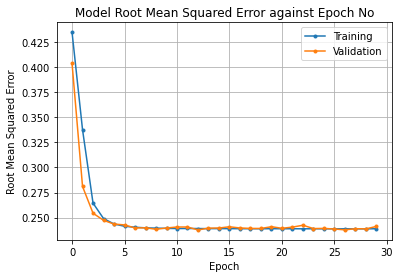

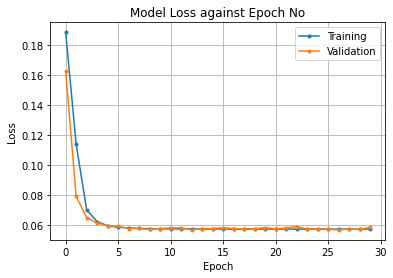

In [7]:
batchsize=64; epoch=30; lr=0.001
net = autEncA('autEncA'); net.cuda()
trainLoader, valLoader, testLoader = loadData(batchsize, mode='auto', altArg={'path':'saved/bboxMasked'})
_ = trainNet(net, [trainLoader, valLoader], batchsize, epoch, lr, trainType='AutoEnc')